## Paper name: "Human Level Control through deep Reinforcement Learning" 


In [ ]:
import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import keras
import cv2
from skimage.color import rgb2gray
from collections import deque
from PIL import Image, ImageDraw
from skimage.transform import resize
import matplotlib.pyplot as plt

In [0]:
from keras.models import Sequential, Model
from keras.models import load_model, save_model
from keras.layers import Input, Add, Dense, Activation, Flatten, MaxPooling2D, ZeroPadding2D, AveragePooling2D, TimeDistributed
from keras.layers import Convolution2D as Conv2D
from keras.optimizers import Adam, RMSprop, SGD
import imageio
from skimage import img_as_ubyte
import keras.backend as K
import tensorflow as tf
from keras.layers import Lambda
from keras.layers import Input, Conv2D, Flatten, Dense, LeakyReLU, Multiply, Maximum, Add, merge

In [0]:
#ALL HYPERPARAMETERS
#Name of environment to be used
ENV_NAME = 'BreakoutDeterministic-v4'

#Size of replay memory
MEM_SIZE = 100000

#Gamma of Markov decision process
GAMMA = 0.99

#Exploration vs Exploitation
EPSILON = 1
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.9995
TOTAL_FRAMES = 5000000
EPSILON_MAX = 1

LEARNING_RATE = 0.0001
MOMENTUM = 0.001 
MINIBATCH_SIZE = 32

#Number of episodes to be trained on
NUM_EPISODES = 5000

#Frequence in which target network is to be updated
TGT_UPDATE_FREQ = 1000

#Name of directory in which GIFs will be stored 
VIS_DIR = "GIFs"

#Name of final model
MODEL_NAME = "model_double_dqn_breakout.h5"

#Numver of games to explore without Adjusting weights
NUM_EXPLORE = 1000

#Name of temporary model for updatng target network 
TMP_MODEL = 'tmp_model_2.h5'

#Maximum number of No operation actions taken at the beginning of the game
NOOPMAX = 10

#Number of evaluations for testing
NUM_EVAL = 20

In [0]:
#Lists to store loss and reward value per game! 
LOSS_HISTORY = []
REWARD_HISTORY = []
filepath= 1
FCNT = 0

#Frame Count
if not os.path.exists("models"): 
    os.mkdir("models")

In [0]:
class Replay_Memory: 
    '''
    This replay memory clas would act as a buffer in which previous experiences would be stored. 
    It as experiences stored in format [ state, action, reward, next_state, done]
    '''
    def __init__(self, MEM_SIZE = 2000): 
        self.memory = deque(maxlen = MEM_SIZE)
        self.max_size = MEM_SIZE
    def add(self,  state, action, reward, next_state, done): 
        #print(len(self.memory))
        self.memory.append(( state, action, reward, next_state, done))

In [0]:
class Agent:
    '''
    This class would drive all the methods to be carried out by the agent. 
    '''
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        self.memory = Replay_Memory(MEM_SIZE)
        self.gamma = GAMMA
        self.epsilon = EPSILON
        self.epsilon_max = EPSILON_MAX
        self.epsilon_min = EPSILON_MIN
        self.total_frame = TOTAL_FRAMES
        self.slope = (self.epsilon_max - self.epsilon_min)/self.total_frame
        self.epsilon_decay = EPSILON_DECAY
        self.lr = LEARNING_RATE
        self.momentum = MOMENTUM
        self.dummy_input = np.zeros((1,self.action_size))
        self.dummy_batch = np.zeros((MINIBATCH_SIZE,self.action_size))
        self.model = self.build_model()
        #save_model(self.model, TMP_MODEL)
        self.target_model = self.get_tgt_model()
        print("Showing target model's layers")
        self.target_model.summary()
        
    def lambda_out_shape(self, input_shape):
        shape = list(input_shape)
        shape[-1] = 1
        return tuple(shape)
        
    def build_model(self):
        '''
        Model is built in this method
        '''
        input_frame = Input(shape=(84, 84, 4))
        action_one_hot = Input(shape=(self.action_size,))
        conv1 = Conv2D(32, (8, 8), strides=(4, 4), activation='relu')(input_frame)
        conv2 = Conv2D(64, (4, 4), strides=(2, 2), activation='relu')(conv1)
        conv3 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv2)
        flat_feature = Flatten()(conv3)
        hidden_feature = Dense(512)(flat_feature)
        lrelu_feature = LeakyReLU()(hidden_feature)
        q_value_prediction = Dense(self.action_size)(lrelu_feature)
        select_q_value_of_action = Multiply()([q_value_prediction,action_one_hot])
        target_q_value = Lambda(lambda x:K.sum(x, axis=-1, keepdims=True),output_shape=self.lambda_out_shape)(select_q_value_of_action)
        model = Model(inputs=[input_frame,action_one_hot], outputs=[q_value_prediction, target_q_value])
        model.compile(loss=['mse','mse'], loss_weights=[0.0,1.0],optimizer=Adam(self.lr))
        return model

    def get_tgt_model(self):
        '''
        This method would clone the architecture as well as the initial weights of the base model into target model        
        '''
        #self.target_model = load_model(TMP_MODEL, compile= False)

        #print("Clone Success? ")
        #print(np.array_equal(self.model.get_weights(), self.target_model.get_weights()))
        #for i in range(len(self.model.get_weights())):
        #    print(np.array_equal(self.model.get_weights()[i], self.target_model.get_weights()[i]))
        self.target_model = self.build_model()
        self.update_target_model()
        return self.target_model
        
    def update_target_model(self): 
        '''
        This method would update weights of target model
        '''
        #save_model(self.model, TMP_MODEL)
        #self.target_model = load_model(TMP_MODEL, compile= False)
        self.target_model.set_weights(self.model.get_weights())
        return
        #for i in range(len(self.model.get_weights())):
        #    print(np.array_equal(self.model.get_weights()[i], self.target_model.get_weights()[i]))
        
        #return

    def next_action(self, state):
        '''
        Get the next action using epsilon greedy policy for deciding whether to exploit or explore
        '''
        if self.epsilon > self.epsilon_min:
            self.epsilon = self.epsilon_max - self.slope*(FCNT)
        #dummy_batch = np.zeros((self.,self.action_size))
        if (np.random.rand() <= self.epsilon):
            return env.action_space.sample()
        q_values = self.model.predict([np.expand_dims(state,axis=0),self.dummy_input])[0]
        #self.model.predict(np.expand_dims(state, axis=0))
        return np.argmax(q_values[0])

    def store_experience(self, state, action, reward, next_state, done):
        '''
        Store the experience in our replay memory
        '''
        self.memory.add(state, action, reward, next_state, done)
    
    def list2np(self, in_list):
        return np.float32(np.array(in_list))

    def replay(self, batch_size, filepath):
        '''
        Does the back propogation to adjust weights during exploitation action. 
        '''
        dummy_batch = np.zeros((batch_size,self.action_size))
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        terminal_batch = []
        y_batch = []

        # Sample random minibatch of transition from replay memory
        minibatch = random.sample(list(self.memory.memory), batch_size)
        dummy_batch = np.zeros((batch_size,self.action_size))
        for data in minibatch:
            state_batch.append(data[0])
            action_batch.append(data[1])
            reward_batch.append(data[2])
            next_state_batch.append(data[3])
            terminal_batch.append(data[4])

        # Convert True to 1, False to 0
        terminal_batch = np.array(terminal_batch) + 0
        # Q value from target network
        target_q_values_batch = self.target_model.predict([self.list2np(next_state_batch),self.dummy_batch])[0]
        next_action_batch = np.argmax(self.model.predict([self.list2np(next_state_batch),self.dummy_batch])[0], axis=-1)
        for i in range(batch_size):
            y_batch.append(reward_batch[i] + (1-terminal_batch[i])*self.gamma*target_q_values_batch[i][next_action_batch[i]] )
        y_batch = self.list2np(y_batch)
        a_one_hot = np.zeros((batch_size,self.action_size))
        for idx,ac in enumerate(action_batch):
            a_one_hot[idx,ac] = 1.0

        loss = self.model.train_on_batch([self.list2np(state_batch),a_one_hot],[self.dummy_batch,y_batch])
        
        LOSS_HISTORY.append(loss[1])
        
        if(filepath % TGT_UPDATE_FREQ == 0):
            self.update_target_model()
            print("Target model updated Successfully!")
            
        return 

In [0]:
def generate_gif(frame_no, frames, reward, path, e):
    '''
    Utility method to generate gif from frames
    '''
    for idx, frame_idx in enumerate(frames): 
        frames[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"episode_{0}_frame_{1}_reward_{2}.gif".format(e, frame_no, reward)}', 
                    frames, duration=1/100)


In [0]:
def preprocess(frame):
    '''
    This method resizes the frame to 84*84 and converts it to grayscale
    '''
    resized = cv2.resize(frame, (84, 84), interpolation = cv2.INTER_AREA)
    frame_gray = rgb2gray(resized)
    return frame_gray

In [9]:
env = gym.make(ENV_NAME)
agent = Agent(env)











Showing target model's layers
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 84, 84, 4)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 20, 20, 32)   8224        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 9, 9, 64)     32832       conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_5[0][0]                   
____________________________________________________

In [10]:
#INITIAL EXPLORATION: 
'''
THIS IS DONE TO POPULATE REPLAY MEMORY WITH COMPLETE EXPLORATION TO INITIALIZE THE MEMORY 
'''
for e in range(NUM_EXPLORE):
    state = env.reset()
    
    #LAST LIVES = TOTAL NO OF LIVES REMAINING
    last_lives = 5
    
    #CHECKS IF ONE OF THE POSSIBLE LIVES IS LOST OR NOT
    terminal_life_lost = False 
    
    # FIRST ACTION IS ALWAYS 'FIRE' TO INITIATE THE GAME
    state, _, _, _ = env.step(1)
    for _ in range(random.randint(1, NOOPMAX)):
        #DOING RANDOM NO-OPs DURING START OF THE GAME TO STATE WITH A NEW STATE EVERY TIME
        state, _, _, _ = env.step(0)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    rgb_frames.append(state)

    for i in range(4): 
        frames.append(processed_frame)
        
    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(20000):
        agent.epsilon = 1
        if(terminal_life_lost == True):
            state, _, _, _ = env.step(1)
            for _ in range(random.randint(1, 10)):
                state, _, _, _ = env.step(0)
            processed_frame = preprocess(state)
            frames = []
            for i in range(4):
                frames.append(processed_frame)
            state = np.stack(frames[-4:], axis = 2)

        action = env.action_space.sample()

        #execute action
        next_state, reward, done, info = env.step(action)
        if info['ale.lives'] < last_lives:
            terminal_life_lost = True
        else:
            terminal_life_lost = done
        last_lives = info['ale.lives']


        
        #REWARD CLIPPING IS DONE HERE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
        
        total_reward = total_reward + reward
        processed_frame = preprocess(next_state)
        processed_frame = processed_frame.astype(np.uint8)
        frames = frames[-3:]
        frames.append(processed_frame)
        #print(processed_frame.shape)
        next_state = np.stack(frames[-4:], axis = 2)
        if(len(frames) != 4):
            print("issue!!")

        #Store experience in replay mem
        agent.store_experience(state, action, reward, next_state, terminal_life_lost)
        state = next_state
        
        if done: 
            if(e % 100 == 0):
                print("Finished exploring for {} episodes".format(e))
            break
print("EXPLORATION STEP COMPLETED")

Finished exploring for 0 episodes
EXPLORATION STEP COMPLETED




e =  10  eps =  0.997723  This reward =  1.0  Frame_cnt =  1151
e =  20  eps =  0.99541234  This reward =  0.0  Frame_cnt =  2318
Finished episode  25 / 5000  Total reward =  0.88
e =  30  eps =  0.99290566  This reward =  0.0  Frame_cnt =  3584
e =  40  eps =  0.99025444  This reward =  5.0  Frame_cnt =  4923
Finished episode  50 / 5000  Total reward =  1.12
e =  50  eps =  0.98732602  This reward =  0.0  Frame_cnt =  6402
e =  60  eps =  0.98473816  This reward =  1.0  Frame_cnt =  7709
e =  70  eps =  0.98206516  This reward =  0.0  Frame_cnt =  9059
Finished episode  75 / 5000  Total reward =  1.08
e =  80  eps =  0.97961194  This reward =  0.0  Frame_cnt =  10298
e =  90  eps =  0.9768142  This reward =  2.0  Frame_cnt =  11711
Finished episode  100 / 5000  Total reward =  1.32
e =  100  eps =  0.9737452  This reward =  2.0  Frame_cnt =  13261
e =  110  eps =  0.970993  This reward =  2.0  Frame_cnt =  14651
e =  120  eps =  0.9684883  This reward =  1.0  Frame_cnt =  15916
Fini

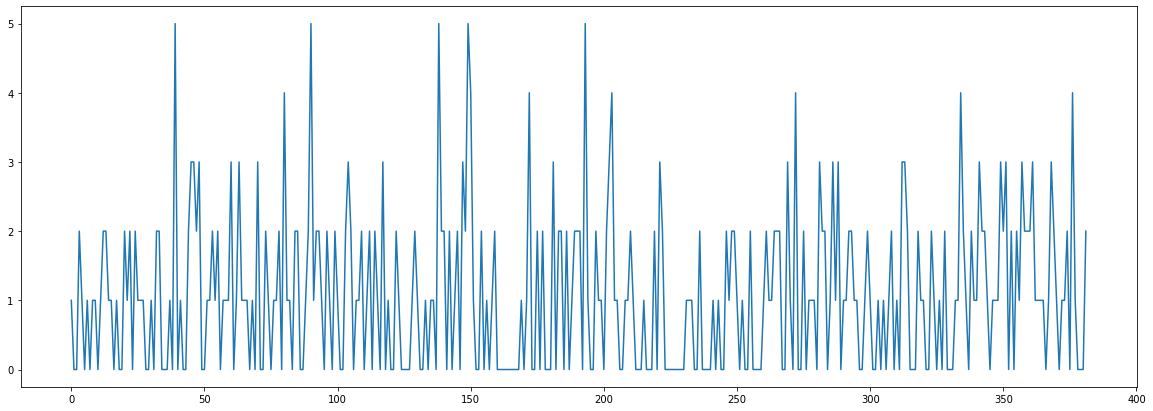

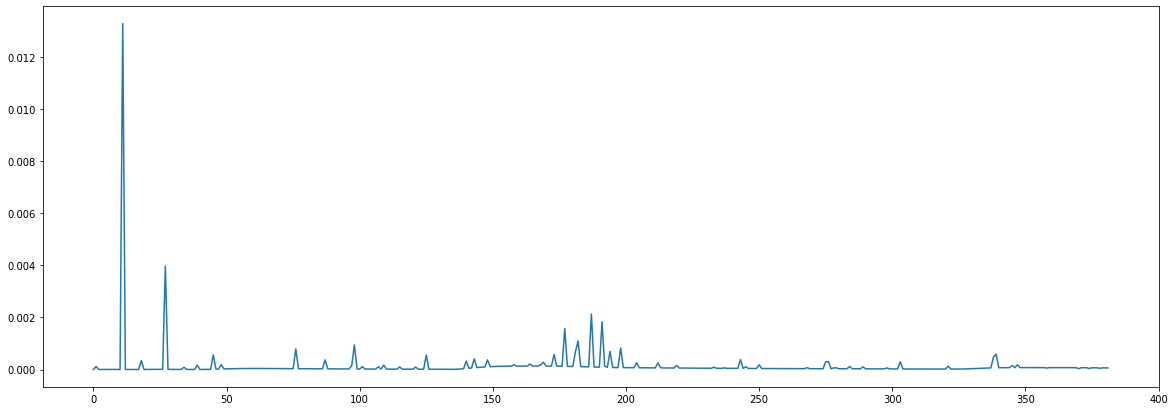

e =  390  eps =  0.89875864  This reward =  0.0  Frame_cnt =  51133
Finished episode  400 / 5000  Total reward =  1.2
e =  400  eps =  0.8959708  This reward =  3.0  Frame_cnt =  52541


In [0]:
'''
TRAIN DQN ON THE GAME
'''
rew_list = []
for e in range(1, NUM_EPISODES+1):
    
    state = env.reset()
    #LAST LIVES = TOTAL NO OF LIVES REMAINING
    last_lives = 5
    terminal_life_lost = False 
    # FIRST ACTION IS ALWAYS 'FIRE' TO INITIATE THE GAME   
    state, _, _, _ = env.step(1)
    for _ in range(random.randint(1, 10)):
        #DOING RANDOM NO-OPs DURING START OF THE GAME TO STATE WITH A NEW STATE EVERY TIME
        state, _, _, _ = env.step(0)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    rgb_frames.append(state)

    for i in range(4):
        frames.append(processed_frame)

    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(1, 20000):
        #select an action
        if(terminal_life_lost == True):
            state, _, _, _ = env.step(1)
            for _ in range(random.randint(1, NOOPMAX)):
                state, _, _, _ = env.step(0)
            processed_frame = preprocess(state)
            frames = []
            for i in range(4):
                frames.append(processed_frame)
            state = np.stack(frames[-4:], axis = 2)

        action = agent.next_action(state)
        FCNT = FCNT + 1

        #execute action
        next_state, reward, done, info = env.step(action)
        if info['ale.lives'] < last_lives:
            terminal_life_lost = True
        else:
            terminal_life_lost = done
        last_lives = info['ale.lives']

        if(e % 25 == 0):
            rgb_frames.append(next_state)
        
        #REWARD CLIPPING IS DONE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
        
        total_reward = total_reward + reward
        processed_frame = preprocess(next_state)
        processed_frame = processed_frame.astype(np.uint8)
        frames = frames[-3:]
        frames.append(processed_frame)
        next_state = np.stack(frames[-4:], axis = 2)

        #Store experience in replay mem
        agent.store_experience(state, action, reward, next_state, terminal_life_lost)
        #print(len(agent.memory.memory), itr)
        state = next_state
        
        
        if(FCNT % 50000 == 0):
            fname= "models/tmp_model_" + str(FCNT) + ".h5" 
            save_model(agent.model, fname)
            #plt.figure(figsize=(20,7))
            #plt.plot(REWARD_HISTORY)
            #plt.show()
            #plt.figure(figsize=(20,7))
            #plt.plot(LOSS_HISTORY)
            #plt.show()
           
            
        if done:
            REWARD_HISTORY.append(total_reward)
            rew_list.append(total_reward)
            
            if(e % 25 == 0):
                print("Finished episode ", e , "/", NUM_EPISODES, " Total reward = ", sum(rew_list)/len(rew_list))
                
                if not os.path.exists(VIS_DIR):
                    os.mkdir(VIS_DIR)
                generate_gif(len(rgb_frames), rgb_frames, sum(rew_list)/(len(rew_list)), VIS_DIR + "/", e)
                
                rew_list = []
            break

    
    agent.replay(MINIBATCH_SIZE, filepath)
    filepath = filepath + 1
    if(e % 10 == 0):
        print("e = ", e, " eps = ", agent.epsilon, " This reward = ", total_reward, " Frame_cnt = ", FCNT)
    

save_model(agent.model, "models/" + MODEL_NAME)
print("Model Saved Successfully!! , Partyyyy")

In [0]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50,7))
plt.plot(REWARD_HISTORY)
plt.show()

In [0]:
plt.figure(figsize=(50,10))
plt.plot(LOSS_HISTORY)
plt.show()

In [0]:
#########
#EVALUATE
#########
rew_list = []
for e in range(NUM_EVAL):
    state = env.reset()
    last_lives = info['ale.lives']
    terminal_life_lost = False 
    state, _, _, _ = env.step(1)
    for _ in range(random.randint(1, NOOPMAX)):
        state, _, _, _ = env.step(0)
    total_reward = 0
    processed_frame = preprocess(state)
    frames = []
    rgb_frames = []
    rgb_frames.append(state)
    for i in range(4):
        frames.append(processed_frame)
   
    state = np.stack(frames[-4:], axis = 2)

    diff = 0
    for itr in range(20000):
        #select an action
        if(terminal_life_lost == True):
            state, _, _, _ = env.step(1)
            for _ in range(random.randint(1, NOOPMAX)):
                state, _, _, _ = env.step(0)
            processed_frame = preprocess(state)
            frames = []
            for i in range(4):
                frames.append(processed_frame)
            state = np.stack(frames[-4:], axis = 2)

        #action = agent.next_action(state)
        action = np.argmax(agent.model.predict(np.expand_dims(state, axis=0)))
        FCNT = FCNT + 1
        #execute action
        next_state, reward, done, info = env.step(action)
        if info['ale.lives'] < last_lives:
            terminal_life_lost = True
        else:
            terminal_life_lost = done
        last_lives = info['ale.lives']
        rgb_frames.append(next_state)
       
        #REWARD CLIPPING IS DONE
        if(reward > 0):
            reward = 1
        elif(reward < 0):
            reward = -1
       
        total_reward = total_reward + reward
        processed_frame = preprocess(next_state)
        processed_frame = processed_frame.astype(np.uint8)
        frames = frames[-3:]
        frames.append(processed_frame)
        next_state = np.stack(frames[-4:], axis = 2)

        #Store experience in replay mem
        #agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        
        if done:
            rew_list.append(total_reward)
            #REWARD_HISTORY.append(total_reward)
            #rew_list.append(total_reward)
            
            #if(e % 25 == 0):
            print("Finished episode ", e , "/", NUM_EVAL, " Total reward = ", sum(rew_list)/len(rew_list))
            if not os.path.exists("test"):
                os.mkdir("test")
            generate_gif(len(rgb_frames), rgb_frames, sum(rew_list)/(len(rew_list)), "test/", e)
           
            #rew_list = []
            break

   
print("Testing Complete")
